### Introduction

Mechanistic interpretability comes from a blend of three intellectual regimes namely- neuroscience and cognitive science, feature visualization and a proper formalism of the idea - which investigated the representation of patterns/ algorithms that are present within  the weights. The proper formalism came after 2018, while feature visualization had already gained a lot of traction in the 2010s.  Introduced by  *Chris Olah et.al, 2020*  , the core idea rests on understanding mechanistic implementations of neurons in terms of their weights. Instead of asking “what input-output correlations does a model learn?” the question we ask here is - “what algorithms are being implemented inside the weights?”.

In neuroscience , researchers try to explain cognition in terms of circuits: neurons, layers, connections, receptive fields. Early interpretability work borrowed this analogy: if neural networks are “artificial brains,” maybe we can study their circuits too.

A lot of the work in neural networks focuses on the idea of decoding the inner world within our models. But what if we take an approach inspired by neuroscience that requires us to zoom in? What if we treated individual neurons, even individual weights, as being worthy of serious investigation?. This opens up a world of entirely new possibilities.  Instead of looking at neural networks as a "black box" which is what we typically do , we can look at the patterns/algorithms that emerge from within the connections or "circuits".

As a model trains, we can see a dog's head form from a face, eyes, tongue etc. Similarly, we can see a landscape image form from trees, houses , grass etc. These two examples correspond from low-level feature analysis to high-level representations. We can do the same thing with logic gates as well. Speaking of analyzing such features, we have to discuss circuits and connections which represents a fundamental regime for understanding mechanistic interpretability




### Circuits-  features and visualizing weights


Features are one of the most fundamental properties of Neural Networks. If you think of a direction vector in a vector space of activations of neurons in a given layer , this can correspond to directions in within a feature space. Even though, indiviual neurons can be studied, these features can be connected by weights forming circuits.

The circuits can be thought of as computational graphs that consist of a  set of features, and the weighted edges that go between them in the original network. The question here is- are these vector spaces of neurons understandable ?. Can these indiviual neurons be studied ?. The answer lies in mechanistically interpreting these circuits at a deeper level.

Making use of the vector space  of neurons, in particular their weights, one can contextualize the weights in a broader context of the network *C.Olah et.al, 2018* . The challenge of contextualization is a recurring one in understanding neural networks: we can easily observe every activation, every weight, and every gradient; the challenge lies in determining what those values represent.


Below is an example where we are loading a pre-trained VGG16  and selecting a convolutional layer an channel inside of it. A random input image of a dog is used. We are optimizing the pixels (via gradient ascent) to maximize activation of that neuron channel. Then the resulting synthetic image is displayed. The result is usually a patterned texture (e.g., stripes, curves, eyes), showing what kind of input strongly excites that channel.

#### Why Gradient ascent ?

Since, we interested in maximizing the activation view, which is essentially giving us information on the input pattern that excites the network, we need to consider a kind of gradient which  does not minimize the error. Hence , we can flip the sign. This is called gradient ascent.  In short, we use gradient ascent because the problem is a maximization (not minimization). It is the exact mirror of gradient descent, but instead of training weights, we are “training” the input image to excite the model.

\begin{equation*}
x \leftarrow x + \eta\Delta_x f(x ; \theta)
\end{equation*}

where,  $f(x ; \theta)$ is the activation of the chosen neuron/channel given input $x$. $\theta$ is the fixed network parametres. The interpretation can be  is that each step of gradient ascent moves “uphill” to make the neuron “fire” more strongly. The resultant $x$ is a  synthetic pattern that reveals what that neuron/channel is tuned to. Gradient ascent also utilizes local information to efficiently climb towards higher activation inputs.


Step 0, Loss -1.218991994857788
Step 10, Loss -59.59365463256836
Step 20, Loss -110.49378204345703
Step 30, Loss -161.10321044921875
Step 40, Loss -214.4677734375
Step 50, Loss -271.0986022949219
Step 60, Loss -330.8155822753906
Step 70, Loss -393.2688903808594
Step 80, Loss -458.10302734375
Step 90, Loss -524.7427368164062


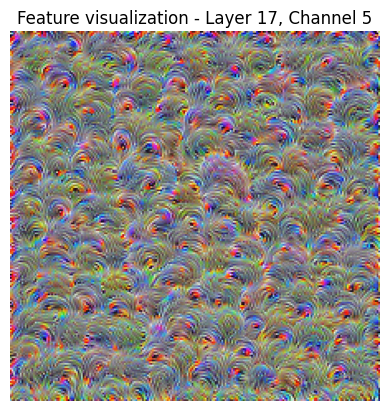

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# 1. Load pretrained VGG16
vgg = models.vgg16(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()

# 2. Choose the layer and channel we want to visualize. We can choose any layer
layer_idx = 17   # e.g. 17th layer (Conv4_2)
channel_idx = 5 # e.g. 5th channel in that layer

# 3. Hook to grab activations
activations = {}
def hook_fn(module, input, output):
    activations['value'] = output

hook = vgg[layer_idx].register_forward_hook(hook_fn)


img = Image.open("/content/dog.jpg")
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to VGG16 input size
    transforms.ToTensor()
])
image_tensor = transform(img).unsqueeze(0).requires_grad_(True) # Add batch dimension and enable gradient tracking


# 5. Optimize the image to maximize channel activation
optimizer = optim.Adam([image_tensor], lr=0.1)

for step in range(100):
    optimizer.zero_grad()
    vgg(image_tensor)
    loss = -activations['value'][0, channel_idx].mean()
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}, Loss {loss.item()}")

# 6. Convert tensor to image
def to_img(x):
    x = x.detach().clone()
    x = x.squeeze().permute(1, 2, 0)
    x = x - x.min()
    x = x / x.max()
    return x

visual = to_img(image_tensor)

# 7. Plot result
plt.imshow(visual)

plt.title(f"Feature visualization - Layer {layer_idx}, Channel {channel_idx}")
plt.axis("off")
plt.show()

# Remove hook
hook.remove()

In [ ]:

img = Image.open("/content/dog.jpg")
transform = transforms.ToTensor()
image_tensor = transform(img)
image_tensor

tensor([[[0.3333, 0.3333, 0.3294,  ..., 0.1804, 0.1804, 0.1804],
         [0.3373, 0.3333, 0.3333,  ..., 0.1686, 0.1725, 0.1725],
         [0.3412, 0.3373, 0.3373,  ..., 0.1686, 0.1725, 0.1725],
         ...,
         [0.2706, 0.2588, 0.2667,  ..., 0.4314, 0.4627, 0.4667],
         [0.2471, 0.2353, 0.2431,  ..., 0.4627, 0.4667, 0.4549],
         [0.2314, 0.2157, 0.2275,  ..., 0.4627, 0.4588, 0.4588]],

        [[0.3176, 0.3176, 0.3137,  ..., 0.1804, 0.1804, 0.1804],
         [0.3216, 0.3176, 0.3176,  ..., 0.1686, 0.1725, 0.1725],
         [0.3255, 0.3216, 0.3216,  ..., 0.1686, 0.1725, 0.1725],
         ...,
         [0.4235, 0.4118, 0.4157,  ..., 0.4627, 0.4980, 0.5020],
         [0.4039, 0.3922, 0.3922,  ..., 0.4941, 0.5020, 0.4902],
         [0.3882, 0.3725, 0.3765,  ..., 0.4941, 0.4941, 0.4941]],

        [[0.2706, 0.2706, 0.2667,  ..., 0.1804, 0.1804, 0.1804],
         [0.2745, 0.2706, 0.2706,  ..., 0.1686, 0.1725, 0.1725],
         [0.2784, 0.2745, 0.2745,  ..., 0.1686, 0.1725, 0.

A toy extension of our vgg visualization. Weight context is added with a pytorch sketch.

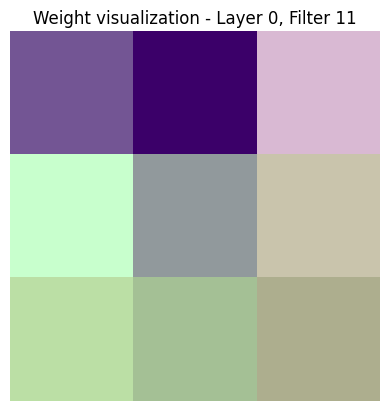

In [ ]:
import torch
from torchvision import models
import matplotlib.pyplot as plt

# Load pretrained VGG16
vgg = models.vgg16(pretrained=True).features
layer_idx = 0 # visualize first conv layer
conv = vgg[layer_idx]

# Extract weights of chosen filter
weights = conv.weight.data.clone()
channel_idx = 11

# Normalize for visualization
w = weights[channel_idx]
w = (w - w.min()) / (w.max() - w.min())

# Plot the filter (weight template)
plt.imshow(w.permute(1, 2, 0))
plt.title(f"Weight visualization - Layer {layer_idx}, Filter {channel_idx}")
plt.axis("off")
plt.show()

We can now pair  this with gradient-ascent feature visualization (the earlier code).

Here the weight visualization shows the “template” stored in parameters.The activation maximization shows the “preferred input pattern.”

We will take VGG16, pick a convolutional filter, and show side by side:

The weight template (raw filter weights visualized as an image) and the feature visualization (image found by gradient ascent that excites the filter).

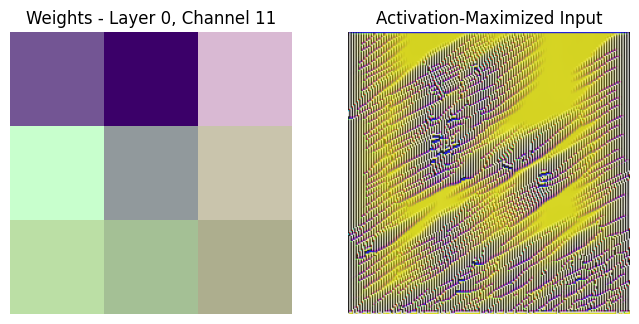

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# -------------------------
# 1. Load pretrained VGG16
# -------------------------
vgg = models.vgg16(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()

# -------------------------
# 2. Choose layer & channel
# -------------------------
layer_idx = 0      # First conv layer (Conv1_1)
channel_idx = 11    # Pick the 5th filter

conv = vgg[layer_idx]

# -------------------------
# 3. Weight Visualization
# -------------------------
weights = conv.weight.data.clone()
w = weights[channel_idx]

# Normalize for display
w_norm = (w - w.min()) / (w.max() - w.min())
weight_img = w_norm.permute(1, 2, 0).detach().cpu()

# -------------------------
# 4. Feature Visualization (Gradient Ascent)
# -------------------------
# Hook to grab activation
activations = {}
def hook_fn(module, input, output):
    activations['value'] = output

hook = conv.register_forward_hook(hook_fn)

# Random input image
img = Image.open("/content/dog.jpg")
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to VGG16 input size
    transforms.ToTensor()
])
image_tensor = transform(img).unsqueeze(0).requires_grad_(True) # Add batch dimension and enable gradient tracking


# Optimize input to maximize channel activation
optimizer = optim.Adam([image_tensor], lr=0.1)
for step in range(100):
    optimizer.zero_grad()
    vgg(image_tensor)
    loss = -activations['value'][0, channel_idx].mean()
    loss.backward()
    optimizer.step()

# Convert tensor -> displayable image
def to_img(x):
    x = x.detach().clone()
    x = x.squeeze().permute(1, 2, 0)
    x = x - x.min()
    x = x / x.max()
    return x.cpu()

feature_img = to_img(image_tensor)

# Remove hook
hook.remove()

# -------------------------
# 5. Plot side by side
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(weight_img)
axs[0].set_title(f"Weights - Layer {layer_idx}, Channel {channel_idx}")
axs[0].axis("off")

axs[1].imshow(feature_img)
axs[1].set_title("Activation-Maximized Input")
axs[1].axis("off")

plt.show()


- Left: the actual convolutional filter (weights). It looks like a little RGB patch — often like edge detectors or color blobs in the first layer.

- Right: the synthetic image generated by gradient ascent that maximally excites that filter. This gives weight contextualization: the filter’s template vs. what it “wants” to see in an input.

Next is the general purpose code where we can visualize any layer. We can pick any convolutional layer and see the weights (filters) and the feature visualizations (optimized inputs that excite them)

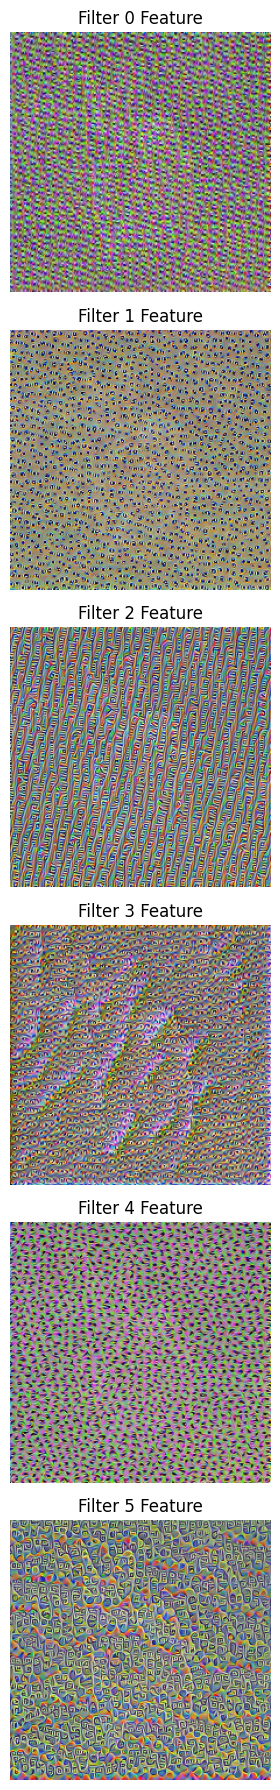

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# -------------------------
# 1. Load pretrained VGG16
# -------------------------
vgg = models.vgg16(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()

# -------------------------
# 2. Utility functions
# -------------------------
def normalize_img(x):
    """Normalize tensor to [0,1] for display."""
    x = x.detach().clone()
    x = x.squeeze().permute(1, 2, 0)
    x = x - x.min()
    x = x / x.max()
    return x.cpu()

def visualize_layer(layer_idx, n_filters=6, steps=50, lr=0.1, img_size=64):
    """
    Visualize weights and feature-optimized inputs for a chosen conv layer.

    Args:
        layer_idx (int): index of convolutional layer in vgg.features
        n_filters (int): number of filters to visualize
        steps (int): gradient ascent steps
        lr (float): learning rate for ascent
        img_size (int): size of synthetic image
    """
    layer = vgg[layer_idx]
    if not isinstance(layer, nn.Conv2d):
        raise ValueError(f"Layer {layer_idx} is not Conv2d.")

    weights = layer.weight.data.clone()
    n_filters = min(n_filters, weights.shape[0])

    # Determine if weight visualization is possible (only for layers with 3 input channels)
    can_visualize_weights = weights.shape[1] == 3

    # Hook to capture activations
    activations = {}
    def hook_fn(module, input, output):
        activations['value'] = output
    hook = layer.register_forward_hook(hook_fn)

    # Adjust figure size based on whether weights are visualized
    fig, axs = plt.subplots(n_filters, 2 if can_visualize_weights else 1, figsize=(6 if can_visualize_weights else 3, 3*n_filters))

    for f in range(n_filters):
        # ---- Weight visualization (only for layers with 3 input channels) ----
        if can_visualize_weights:
            w = weights[f]
            w_norm = (w - w.min()) / (w.max() - w.min())
            weight_img = w_norm.permute(1, 2, 0).cpu()

            axs[f, 0].imshow(weight_img)
            axs[f, 0].set_title(f"Filter {f} Weights")
            axs[f, 0].axis("off")
            feature_ax = axs[f, 1]
        else:
            feature_ax = axs[f] # If no weight visualization, use the single column of axes


        # ---- Feature visualization (gradient ascent) ----
        img = Image.open("/content/dog.jpg")
        transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resize the image to VGG16 input size
        transforms.ToTensor()])
        image_tensor = transform(img).unsqueeze(0).requires_grad_(True) # Add batch dimension and enable gradient tracking

        optimizer = optim.Adam([image_tensor], lr=lr)

        for step in range(steps):
            optimizer.zero_grad()
            vgg(image_tensor)
            # Ensure the image size is compatible with the network's expected input
            # This might require padding or resizing if using a layer other than the first
            # For now, we'll assume the img_size is handled appropriately by the network
            # or that we are only visualizing layers that can handle this input size.

            # Accessing the correct activation tensor based on the forward pass output shape
            # and the chosen filter index 'f'.
            # Note: The shape of activations['value'] depends on the layer.
            # For Conv2d layers, the output shape is typically (batch_size, num_filters, height, width)
            # We want the mean activation for the chosen filter across its spatial dimensions.
            # This line assumes activations['value'] has the shape (batch_size, num_filters, ...)
            # and we are taking the mean over all dimensions except the batch size and filter index.
            loss = -activations['value'][0, f].mean()

            loss.backward()
            optimizer.step()

        feature_img = normalize_img(image_tensor)
        feature_ax.imshow(feature_img)
        feature_ax.set_title(f"Filter {f} Feature")
        feature_ax.axis("off")


    plt.tight_layout()
    plt.show()
    hook.remove()

# -------------------------
# 3. Example Usage
# -------------------------
# Visualize first conv layer (layer_idx=0), top 6 filters
#visualize_layer(layer_idx=0, n_filters=6, steps=40, img_size=64)

# Try deeper layer (e.g. layer_idx=17 for Conv4_2)
# Note: Weight visualization is skipped for this layer as it doesn't have 3 input channels.
visualize_layer(layer_idx= 10,  n_filters=6, steps=40, img_size=128)

Normal babygpt

In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from math import sqrt


words = open(r"/content/shakespeare.txt", 'r' , encoding='utf-8').read().split()

chars = sorted(list(set(words)))
string2integer = {ch: i for i, ch in enumerate(chars)}


integer2string = {i:ch for ch,i in string2integer.items()}
encode = lambda s: [string2integer[c] for c in s]

decode = lambda l: ''.join([integer2string[i] for i in l])
data = torch.tensor(encode(words), dtype = torch.long)

vocab_size = len(chars)

block_size = 8
batch_size = 16
embedded_dim = 16
num_heads = 4
num_layers = 4



torch.manual_seed(1337)
class Attention(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super(Attention, self).__init__()
    self.atten = nn.Linear(embedded_dim, 3 * embedded_dim)
    self.projection = nn.Linear(embedded_dim, embedded_dim)
    self.num_heads = num_heads
    self.embedded_dim = embedded_dim
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    # Add an attribute to store attention weights
    self.attention_weights = None


  def forward(self, x):
    B,T,C = x.size()
    q, k ,v  = self.atten(x).split(self.embedded_dim, dim=2)
    q = q.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
    k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
    v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)


    # manual implementation of attention
    # from karpathy
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    # Store attention weights
    self.attention_weights = att

    y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
    y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

    # output projection
    y = self.projection(y)
    return y

dropout = 0.1
class FeedForward(nn.Module):
  def __init__(self, embedded_dim):
    super(FeedForward, self).__init__()
    self.net = nn.Sequential(nn.Linear(embedded_dim, 4 * embedded_dim),
    nn.Linear(4 * embedded_dim, embedded_dim),
    nn.GELU(),
    nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)

### A simple Transformer Block
class Transformer(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super(Transformer, self).__init__()
    self.attention = Attention(embedded_dim,  num_heads)
    self.feed_forward = FeedForward(embedded_dim)
    self.layer_norm_1 = nn.LayerNorm(embedded_dim)
    self.layer_norm_2 = nn.LayerNorm(embedded_dim)

  def forward(self, x):

    x = x + self.attention(self.layer_norm_1(x))
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x


class BabyGPTmodel(nn.Module):
  def __init__(self, vocab_size, block_size, num_layers, embedded_dim, num_heads):
    super(BabyGPTmodel, self).__init__()
    self.token = nn.Embedding(vocab_size, embedded_dim)
    self.positional_embeddings = nn.Embedding(block_size, embedded_dim)
    self.layers1 = nn.ModuleList([Transformer(embedded_dim, num_heads) for _ in range(num_heads)])
    self.ln_f = nn.LayerNorm(embedded_dim, eps = 1e-12) # final layer
    self.ln_head = nn.Linear(embedded_dim, vocab_size)


    # init all weights
    ## from karpathy
    self.apply(self._init_weights)
    # apply special scaled init to the residual projections, per GPT-2 paper
    for pn, p in self.named_parameters():
      if pn.endswith('projection.weight'):
        torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * num_layers))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx):
    device = idx.device
    b, t = idx.size()
    tok_emb = self.token(idx)
    position_ids = torch.arange(0, t, dtype = torch.long).unsqueeze(0)
    pos_emb = self.positional_embeddings(position_ids)
    x = tok_emb + pos_emb
    for layers1 in self.layers1:
      x = layers1(x)
    x = self.ln_f(x)
    logits = self.ln_head(x[:, -1, :])
    return logits

# generate a small batch of data of inputs x and targets y

ix = torch.randint(len(data) - block_size, (batch_size,))
x = torch.stack([data[i:i+block_size] for i in ix])
y = torch.stack([data[i+block_size] for i in ix])
print( x, y)
# Dataset: all pairs (a, b) with label (a+b) mod N


gpt = BabyGPTmodel(vocab_size, block_size, num_layers, embedded_dim, num_heads)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

## Training
for i in range(1000):
    logits = gpt(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(i, loss.item())


# generate from the model
context = torch.zeros((1, 1), dtype=torch.long)
print(decode((context)[0].tolist()))
# samplinf from the probability distribution is added in the notebook.

tensor([[50787, 17350,  8212, 61123, 18205, 23400, 11072, 47328],
        [39423, 14964, 64144, 32402, 46828, 32316, 18580, 30649],
        [45169, 46828, 45355, 12695,  2410, 66146, 53951,  2411],
        [ 1423, 10636,  4823, 11013, 15555,  3540, 11469,  3539],
        [58467, 20442, 34471, 47360, 57328,  1928, 43207, 17106],
        [15430, 18580, 60551,  7372, 23176, 20625, 40223, 11471],
        [17106, 50566, 10903, 42130, 17106, 36585, 56927, 66992],
        [60524, 28938, 14957, 40223, 65437, 36865, 39274, 36865],
        [66610, 37247, 38007, 37707, 61383, 64947,  7982, 21958],
        [ 1928, 22640, 63688, 61174, 61470,  6195, 14025, 55483],
        [60557, 17106, 35929, 38836, 18580, 63712, 38007, 19241],
        [12304, 46107, 45027, 23682, 15070, 41046,  7725, 28863],
        [40160, 60551, 38579, 10112,  3254,  6237,   490, 48250],
        [50825, 61383, 43954, 43790, 62558, 38588, 56201, 18580],
        [ 6301, 10590, 47696, 40936, 16263,  8212, 64906, 17259],
        [4

Trained about 5 minutes on T4. 1000 steps. 85M parametres. On ALL_eminem.text song lyrics. block_Size = 128,  num_layers = 12

Also trained on shakespeare dataset.

In [ ]:
# -------------------- FLOPs Estimation --------------------
def estimate_flops(seq_len, training=True):
    d = embedded_dim
    h = num_heads
    L = num_layers

    attn = 2 * h * seq_len * (d // h) * seq_len   # QKᵀ + AV
    mlp = 8 * d * d                              # FFN
    proj = 4 * d * d                             # Q,K,V,O

    flops_per_layer = attn + mlp + proj
    total = L * flops_per_layer * seq_len

    if training:
        total *= 3  # forward + backward + grad
    return total/1e15

# -------------------- Training --------------------
model = BabyGPT(vocab_size, block_size, num_layers, embedded_dim, num_heads, num_kv_heads, device).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

print("Parameters:", sum(p.numel() for p in model.parameters()))
print("Estimated training FLOPs per batch:", estimate_flops(block_size))

for step in range(20):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix]).to(device)
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix]).to(device)

    opt.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    opt.step()

    if step % 5 == 0:
        print(f"Step {step:02d} | Loss {loss.item():.4f}")

# -------------------- KV Inference Demo --------------------
kv = KVCache(
    num_layers,
    max_len=block_size * 4,
    device=device,
    dtype=next(model.parameters()).dtype,
)
kv.reset()

start = x[:1, :1]
generated = [start.item()]
for _ in range(30):
    logits = model(start, kv_cache=kv)
    nxt = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
    generated.append(int(nxt))
    start = torch.cat([start, nxt], dim=1)
    kv.advance(1)

print("Generated text:")
print(decode(generated))
print("Estimated inference FLOPs per token:", estimate_flops(1, training=False))

Parameters: 217984
Estimated training FLOPs per batch: 3.296722944e-06
Step 00 | Loss 4.5866
Step 05 | Loss 3.8232
Step 10 | Loss 3.4849
Step 15 | Loss 3.2666
Generated text:
r } r<o grL e r w h  a  ttj edh
Estimated inference FLOPs per token: 1.9712e-10


Generate text

In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

# -------------------- Text Generation --------------------
def generate_text(model, start_seq, idx2char, length= 100, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device
    kv = KVCache(model.num_layers, max_len=model.block_size * 5,
                 device=device, dtype=next(model.parameters()).dtype)
    kv.reset()

    generated = [int(start_seq[0, 0].item())]
    input_seq = start_seq.clone()

    for _ in range(length - 1):
        # Only pass the last block_size tokens to the model
        input_for_model = input_seq[:, -model.block_size:]

        logits = model(input_for_model, kv_cache=kv)
        last = logits[:, -1, :] / temperature
        probs = F.softmax(last, dim=-1)
        nxt = torch.multinomial(probs, num_samples=1)
        generated.append(int(nxt.item()))
        input_seq = torch.cat([input_seq, nxt], dim=1)
        kv.advance(1)

    decoded_text = ''.join([idx2char[i] for i in generated])
    return generated, decoded_text

# Start generation with the first token of batch 0
start = x[0:1, 0:1]
indices, text = generate_text(model, start, integer2string, length=100, temperature=0.8)
print("Generated indices:", indices)
print("Generated text:", repr(text))

Generated indices: [73, 64, 74, 75, 1, 73, 46, 68, 80, 1, 67, 20, 78, 75, 1, 63, 1, 14, 75, 74, 1, 26, 1, 1, 1, 1, 60, 60, 1, 68, 34, 60, 75, 56, 64, 60, 79, 0, 14, 1, 60, 1, 1, 69, 70, 74, 73, 1, 60, 74, 80, 1, 80, 80, 1, 1, 1, 76, 60, 5, 60, 1, 76, 67, 56, 56, 73, 60, 1, 60, 1, 1, 80, 55, 21, 1, 1, 76, 56, 70, 1, 73, 74, 1, 1, 64, 74, 74, 1, 75, 1, 78, 60, 60, 1, 56, 70, 1, 28, 1]
Generated text: "rist rUmy l9wt h 3ts A    ee mIetaiex\n3 e  nosr esy yy   ue'e ulaare e  y`:  uao rs  iss t wee ao C "


Calculate the symbolic entropy

In [ ]:
dt = 1.0 # Placeholder: In a real scenario, this would be the time taken for one iteration in seconds
mfu = model.model_flops(batch_size * 1, dt)
print(mfu)
print(f" Model Flop Utilization: {mfu*100:.10f}%")

0.00043548672
 Model Flop Utilization: 0.0435486720%
